# Data Exploration


In [2]:
import pandas as pd

In [28]:
df = pd.read_csv("./playground-series-s4e7/train.csv")

df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1


In [4]:
dfdum = pd.get_dummies(df)
dfdum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     int64  
 1   Age                    int64  
 2   Driving_License        int64  
 3   Region_Code            float64
 4   Previously_Insured     int64  
 5   Annual_Premium         float64
 6   Policy_Sales_Channel   float64
 7   Vintage                int64  
 8   Response               int64  
 9   Gender_Female          bool   
 10  Gender_Male            bool   
 11  Vehicle_Age_1-2 Year   bool   
 12  Vehicle_Age_< 1 Year   bool   
 13  Vehicle_Age_> 2 Years  bool   
 14  Vehicle_Damage_No      bool   
 15  Vehicle_Damage_Yes     bool   
dtypes: bool(7), float64(3), int64(6)
memory usage: 866.8 MB


<Axes: >

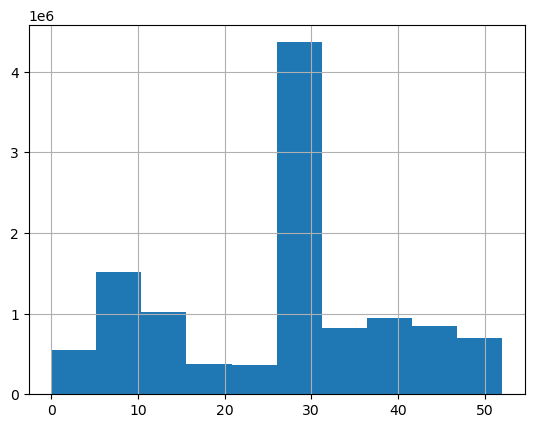

In [5]:
df.Region_Code.hist()

<Axes: xlabel='Response'>

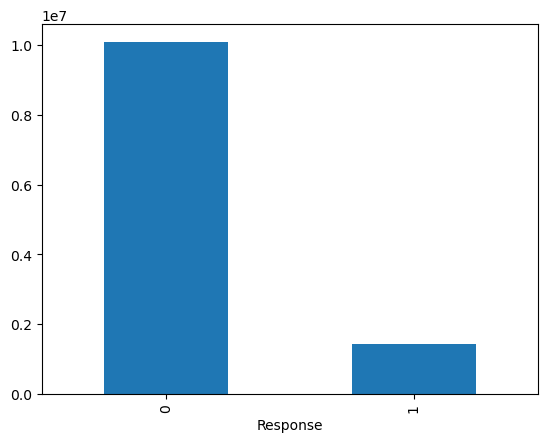

In [6]:
df.Response.value_counts().plot(kind="bar")

In [7]:
zeros = df.Response.value_counts()[0]
ones = df.Response.value_counts()[1]

ones_share = ones / (ones + zeros)

ones_share

0.12299729208631043

<Axes: xlabel='Driving_License'>

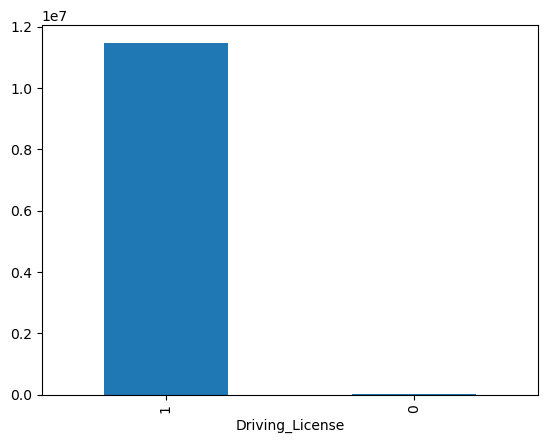

In [8]:
df.Driving_License.value_counts().plot(kind="bar")

<Axes: xlabel='Gender'>

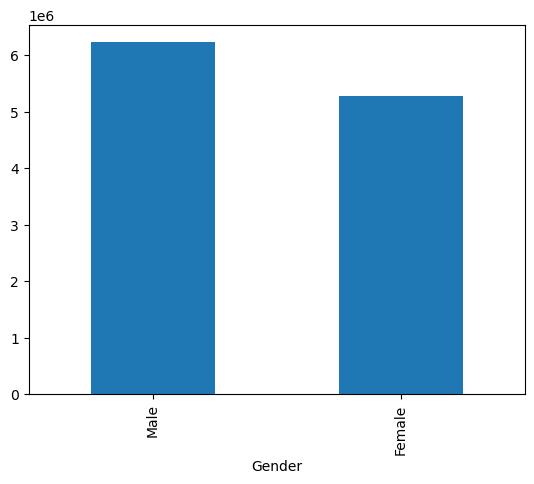

In [9]:
df.Gender.value_counts().plot(kind="bar")

# Dataset definition


In [10]:
import torch

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
print(f"Using {device}")

Using mps


In [11]:
import numpy as np
from torch.utils.data import Dataset


class InsuranceDataset(Dataset):
    def __init__(self, dataframe, contains_labels):
        self.df = dataframe

        self.df = pd.get_dummies(self.df)

        normalized_cols = [
            "Age",
            "Region_Code",
            "Annual_Premium",
            "Policy_Sales_Channel",
            "Vintage",
        ]

        for col in normalized_cols:
            self.df[col] = (self.df[col] - self.df[col].mean()) / self.df[col].std()

        self.contains_labels = contains_labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        id = row["id"]
        row = row.drop("id")

        if self.contains_labels:
            label = torch.tensor(row["Response"], dtype=torch.float)
            row = row.drop("Response")

        data = torch.tensor(row.to_numpy(dtype=np.float32), dtype=torch.float)

        if self.contains_labels:
            return id, data, label
        else:
            return id, data

In [29]:
print(f"Shape of dataframe: {df.shape}")

positive_samples = df[df["Response"] == 1]
negative_samples = df[df["Response"] == 0]

positive_val_share = positive_samples.sample(n=50_000, random_state=42)
negative_val_share = negative_samples.sample(n=50_000, random_state=42)

val_dataframe = pd.concat([positive_val_share, negative_val_share])
print(f"Shape of val dataframe: {val_dataframe.shape}")

val_set = InsuranceDataset(val_dataframe, contains_labels=True)

val_indices = val_dataframe.index
df = df.drop(val_indices)
print(f"Shape of train dataframe: {df.shape}")

train_set = InsuranceDataset(df, contains_labels=True)

val_set[0], val_set[1], val_set[2]

Shape of dataframe: (11504798, 12)
Shape of val dataframe: (100000, 12)
Shape of train dataframe: (11404798, 12)


((5592646,
  tensor([-0.1797,  1.0000,  1.1722,  0.0000,  0.3331, -1.3665, -1.2250,  1.0000,
           0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000]),
  tensor(1.)),
 (11249674,
  tensor([-0.3245,  1.0000, -0.7849,  0.0000, -0.1516,  0.3819,  1.5490,  1.0000,
           0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000]),
  tensor(1.)),
 (6803340,
  tensor([ 1.1233,  1.0000, -0.9480,  0.0000, -1.6844,  0.9528,  0.5825,  0.0000,
           1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000]),
  tensor(1.)))

# Model definition


In [30]:
import torch.nn as nn


class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(14, 128),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            # nn.Sigmoid(),
        )

    def forward(self, input):
        return self.model(input)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(y_true, y_pred):
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

# Training loop


In [36]:
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

train_loader = DataLoader(train_set, batch_size=2048, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=2048, shuffle=False, pin_memory=True)

model = InsuranceModel().to(device)
model.train()

loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1 / ones_share))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.05, weight_decay=0)

for epoch in range(1):
    for i, (id, data, targets) in tqdm(
        enumerate(train_loader), total=len(train_loader)
    ):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()

        output = model(data).squeeze()

        loss_val = loss(output, targets)

        if i % 20 == 0:
            print(f"Train loss: {loss_val.item()}")

        loss_val.backward()

        optimizer.step()

        if i % 100 == 0:
            model.eval()
            with torch.no_grad():
                val_loss = 0

                ground_truth = []
                predictions = []

                for id, data, targets in val_loader:
                    data, targets = data.to(device), targets.to(device)
                    output = model(data).squeeze()
                    val_loss += loss(output, targets).item()

                    ground_truth.extend(targets.cpu().numpy())
                    predictions.extend(output.cpu().numpy())
                print(f"Val loss:   {val_loss / len(val_loader)}")

                ground_truth = np.array(ground_truth).flatten()
                predictions = np.array(predictions).flatten()

                # Calc auc
                auc_metric = plot_roc_curve(ground_truth, predictions)
                print(f"AUC:        {auc_metric}")

                # Calculate accuracy
                predictions = predictions > 0
                accuracy = np.mean(predictions == ground_truth)
                print(f"Accuracy:   {accuracy}")

                # Calculate precision
                precision = np.sum(predictions * ground_truth) / np.sum(predictions)
                print(f"Precision:  {precision}")

                # Calculate recall
                recall = np.sum(predictions * ground_truth) / np.sum(ground_truth)
                print(f"Recall:     {recall}")

                # Calculate F1 score
                f1 = f1_score(ground_truth, predictions)
                print(f"F1 score:   {f1}")

            model.train()

  0%|          | 0/5569 [00:00<?, ?it/s]

Train loss: 1.3106715679168701


# Test evaluation


In [34]:
test_df = pd.read_csv("./playground-series-s4e7/test.csv")

test_set = InsuranceDataset(test_df, contains_labels=False)
test_loader = DataLoader(test_set, batch_size=2048, shuffle=False, pin_memory=True)

model.eval()

sub = []

with torch.no_grad():
    for id, data in tqdm(test_loader):
        data = data.to(device)

        outputs = model(data)

        print(outputs[0])

        outputs = torch.sigmoid(outputs)

        outputs = outputs.detach().squeeze().cpu().numpy()

        sub.extend(zip(id.numpy(), outputs))

sub_df = pd.DataFrame(sub, columns=["id", "Response"])

sub_df.to_csv("submission.csv", index=False)

  0%|          | 0/3746 [00:00<?, ?it/s]

tensor([-1.4870], device='mps:0')
tensor([-6.4192], device='mps:0')
tensor([-6.0404], device='mps:0')
tensor([-0.8936], device='mps:0')
tensor([-6.6172], device='mps:0')
tensor([1.4943], device='mps:0')
tensor([1.2014], device='mps:0')
tensor([0.8354], device='mps:0')
tensor([1.7500], device='mps:0')
tensor([-6.0043], device='mps:0')
tensor([-6.4685], device='mps:0')
tensor([-5.8119], device='mps:0')
tensor([-7.3498], device='mps:0')
tensor([1.1455], device='mps:0')
tensor([-6.4705], device='mps:0')
tensor([-0.2570], device='mps:0')
tensor([-6.4326], device='mps:0')
tensor([-6.1036], device='mps:0')
tensor([1.2375], device='mps:0')
tensor([-4.6612], device='mps:0')
tensor([-0.2653], device='mps:0')
tensor([-3.1024], device='mps:0')
tensor([0.4974], device='mps:0')
tensor([1.4006], device='mps:0')
tensor([-5.3795], device='mps:0')
tensor([1.1618], device='mps:0')
tensor([1.1594], device='mps:0')
tensor([1.4294], device='mps:0')
tensor([1.1894], device='mps:0')
tensor([-5.9590], device='